<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective: Predict Monthly Crude Palm Oil Price Using Convolutional Neural Network (CNN)

In [22]:
!pip install scikeras
!pip install bayesian-optimization

###Load Libraries

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from keras.layers import Dense, Dropout
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold, cross_val_score
from scikeras.wrappers import KerasRegressor
from tensorflow import keras

import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

###Define Functions to Facilitate Metrics Evaluation

In [44]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [103]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/main/Cleaned_data/FS.csv'
df = read_csv(path)
df.head()

,date,cpo_pri,cno_pri,exmaus,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri,wti_spri,tmax_degC,tmin_degC,srad,q_mm,humidity
0,2010-12-01,323,455,2.991388,3102.61,423.45,844.0,468.0,578.0,28.67,30.43,20.2900,207.70504,117.7,79.261905
1,2011-01-01,345,546,2.991388,3100.45,415.85,799.0,485.0,557.0,24.49,31.20,20.9200,228.94287,4.5,82.193548
2,2011-02-01,362,595,2.991388,3199.41,410.77,718.0,466.0,552.0,22.06,31.97,21.0300,238.41747,25.1,74.839286
3,2011-03-01,376,636,2.991388,3281.67,414.82,614.0,442.0,574.0,21.64,32.69,21.6000,218.47599,53.6,77.935484
4,2011-04-01,383,738,2.991388,3261.65,451.04,619.0,429.0,595.0,22.30,32.37,22.0575,226.15010,166.0,80.450000


In [104]:
df.index = pd.to_datetime(df['date'], format='%Y.%m.%d')
del df['date']

In [105]:
df.head()

,cpo_pri,cno_pri,exmaus,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri,wti_spri,tmax_degC,tmin_degC,srad,q_mm,humidity
date,,,,,,,,,,,,,,
2010-12-01,323,455,2.991388,3102.61,423.45,844.0,468.0,578.0,28.67,30.43,20.2900,207.70504,117.7,79.261905
2011-01-01,345,546,2.991388,3100.45,415.85,799.0,485.0,557.0,24.49,31.20,20.9200,228.94287,4.5,82.193548
2011-02-01,362,595,2.991388,3199.41,410.77,718.0,466.0,552.0,22.06,31.97,21.0300,238.41747,25.1,74.839286
2011-03-01,376,636,2.991388,3281.67,414.82,614.0,442.0,574.0,21.64,32.69,21.6000,218.47599,53.6,77.935484
2011-04-01,383,738,2.991388,3261.65,451.04,619.0,429.0,595.0,22.30,32.37,22.0575,226.15010,166.0,80.450000


<Figure size 1800x720 with 0 Axes>

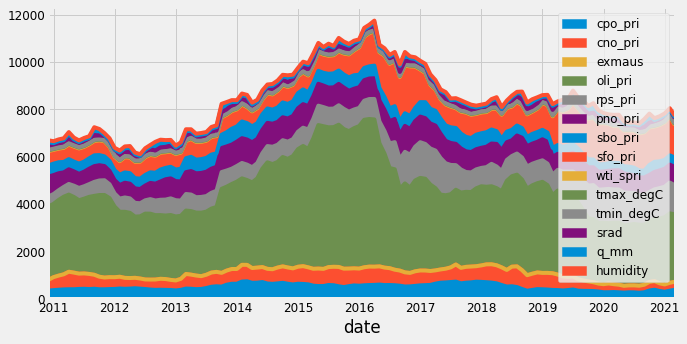

In [106]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('date');
ax.legend(fontsize=12);

##**Convolutional Neural Network Forecasting Technique (CNN)**

###**Split Data into Train Test Segments**

In [125]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 99
Test size: 25


In [126]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

99 25


In [127]:
print(train.shape)
train.head()

(99, 14)


,cpo_pri,cno_pri,exmaus,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri,wti_spri,tmax_degC,tmin_degC,srad,q_mm,humidity
date,,,,,,,,,,,,,,
2010-12-01,323,455,2.991388,3102.61,0.010736,0.528090,0.253193,578.0,0.109026,30.43,20.2900,207.70504,117.7,79.261905
2011-01-01,345,546,2.991388,3100.45,0.004301,0.443820,0.306536,557.0,0.044200,31.20,20.9200,228.94287,4.5,82.193548
2011-02-01,362,595,2.991388,3199.41,0.000000,0.292135,0.246917,552.0,0.006514,31.97,21.0300,238.41747,25.1,74.839286
2011-03-01,376,636,2.991388,3281.67,0.003429,0.097378,0.171609,574.0,0.000000,32.69,21.6000,218.47599,53.6,77.935484
2011-04-01,383,738,2.991388,3261.65,0.034095,0.106742,0.130817,595.0,0.010236,32.37,22.0575,226.15010,166.0,80.450000


###Rescaling Training Data

In [128]:
f_transformer = MinMaxScaler()
feature_columns = ['cno_pri', 'exmaus', 'oli_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'sfo_pri',
                   'wti_spri', 'tmax_degC', 'tmin_degC', 'srad', 'q_mm', 'humidity']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,exmaus,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri,wti_spri,tmax_degC,tmin_degC,srad,q_mm,humidity
date,,,,,,,,,,,,,,
2010-12-01,323,0.112288,1.0,0.140918,0.010736,0.528090,0.253193,0.023302,0.109026,0.468235,0.423798,0.617026,0.366984,0.843364
2011-01-01,345,0.305085,1.0,0.140327,0.004301,0.443820,0.306536,0.009321,0.044200,0.649412,0.629177,0.815738,0.007619,0.983088
2011-02-01,362,0.408898,1.0,0.167408,0.000000,0.292135,0.246917,0.005992,0.006514,0.830588,0.665037,0.904388,0.073016,0.632580
2011-03-01,376,0.495763,1.0,0.189919,0.003429,0.097378,0.171609,0.020639,0.000000,1.000000,0.850856,0.717805,0.163492,0.780147
2011-04-01,383,0.711864,1.0,0.184440,0.034095,0.106742,0.130817,0.034621,0.010236,0.924706,1.000000,0.789608,0.520317,0.899990


In [129]:
cpo_pri_transformer = MinMaxScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

date
2010-12-01    0.0100
2011-01-01    0.0650
2011-02-01    0.1075
2011-03-01    0.1425
2011-04-01    0.1600
Name: cpo_pri, dtype: float64

In [130]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,exmaus,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri,wti_spri,tmax_degC,tmin_degC,srad,q_mm,humidity
date,,,,,,,,,,,,,,
2019-03-01,354,0.637712,0.035196,0.194855,0.382454,0.381292,-0.039662,0.493342,0.455180,0.856471,0.814996,0.707023,0.548889,0.265874
2019-04-01,348,0.533898,0.040707,0.264388,0.393951,0.213633,-0.054975,0.597870,0.515974,0.795294,0.717196,0.732180,0.017143,0.437683
2019-05-01,332,0.400424,0.007766,0.246417,0.453802,0.235262,-0.092159,0.606525,0.530397,0.684706,0.492258,0.708895,0.444127,0.349664
2019-06-01,349,0.317797,-0.048598,0.234308,0.509834,0.320749,-0.074743,0.631824,0.593207,0.663529,0.472698,0.808476,0.181905,0.645800
2019-07-01,372,0.313559,-0.045216,0.223422,0.526454,0.426610,-0.066114,0.773462,0.641749,0.637647,0.462918,0.866202,0.436825,0.577974


In [131]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

date
2019-03-01    0.0875
2019-04-01    0.0725
2019-05-01    0.0325
2019-06-01    0.0750
2019-07-01    0.1325
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [132]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 3
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(96, 3, 14) (96,)


In [ ]:
#test_lag = test[1:23]
#len(test) - 1

In [ ]:
#decrement naturally.
#shifted = test.set_index(["date"]).unstack().shift(3).stack()

###Create Model

In [133]:
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_test.shape[1], X_test.shape[2])))
cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(50, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(1))
cnn_model.compile(loss='mse', optimizer='adam')
cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 2, 64)             1856      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 50)                3250      
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 5,157
Trainable params: 5,157
Non-trainable params: 0
____________________________________________________

In [ ]:
'''
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv1D(filters=8, kernel_size=1, activation='relu', input_shape=(X_test.shape[1], X_test.shape[2]))) #64,32, 16, 8 (best so far)
cnn_model.add(Dropout(0.1))
cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=1))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(4, activation='relu')) #32, 8,4
#cnn_model.add(Dropout(0.1))
cnn_model.add(tf.keras.layers.Dense(1))
#cnn_model.add(Dropout(0.25))
#Dropout(droprate)
cnn_model.compile(loss='mse', optimizer='adam')
cnn_model.summary()
'''

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 3, 8)              56        
                                                                 
 dropout_1 (Dropout)         (None, 3, 8)              0         
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 3, 8)             0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 24)                0         
                                                                 
 dense_6 (Dense)             (None, 4)                 100       
                                                                 
 dense_7 (Dense)             (None, 1)                 5         
                                                      

In [134]:
cnn_history = cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)

Epoch 1/50
3/3 [==============================] - 1s 73ms/step - loss: 0.1048 - val_loss: 0.1691
Epoch 2/50
3/3 [==============================] - 0s 20ms/step - loss: 0.0547 - val_loss: 0.2663
Epoch 3/50
3/3 [==============================] - 0s 15ms/step - loss: 0.0539 - val_loss: 0.2126
Epoch 4/50
3/3 [==============================] - 0s 27ms/step - loss: 0.0292 - val_loss: 0.1236
Epoch 5/50
3/3 [==============================] - 0s 15ms/step - loss: 0.0227 - val_loss: 0.0790
Epoch 6/50
3/3 [==============================] - 0s 15ms/step - loss: 0.0251 - val_loss: 0.0753
Epoch 7/50
3/3 [==============================] - 0s 20ms/step - loss: 0.0171 - val_loss: 0.0953
Epoch 8/50
3/3 [==============================] - 0s 17ms/step - loss: 0.0138 - val_loss: 0.1073
Epoch 9/50
3/3 [==============================] - 0s 15ms/step - loss: 0.0136 - val_loss: 0.0837
Epoch 10/50
3/3 [==============================] - 0s 16ms/step - loss: 0.0096 - val_loss: 0.0536
Epoch 11/50
3/3 [============

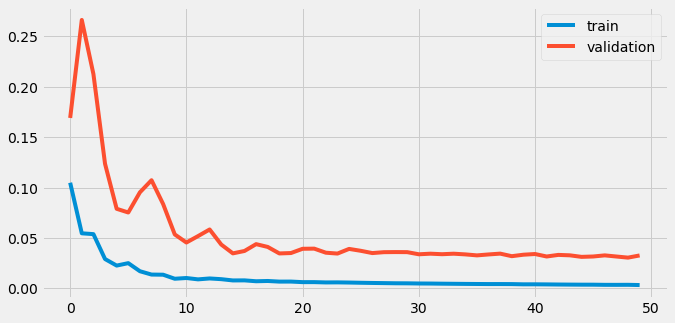

In [135]:
plt.plot(cnn_history.history['loss'], label='train')
plt.plot(cnn_history.history['val_loss'], label='validation')
plt.legend()
plt.show()

The plot show that there is overfitting which mean that there is room for improvement.

{'optimizer': 'Adam', 'learning_rate': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'batch_size': 128, 'activation': 'elu'}

In [ ]:
...updating